# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor, ceil
import math
import nltk
import string
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.matcher import PhraseMatcher
import joblib
import sklearn.externals
import joblib
from profanity_check import predict, predict_prob
import sarcastic

In [98]:
# profanity-check is deprecated and does not work with the latest version of sklearn
# but someone else continues the project under the library alt-profanity-check
# https://gitlab.com/dimitrios/alt-profanity-check
# !pip install alt-profanity-check

In [99]:
sid = SentimentIntensityAnalyzer()

nlp = spacy.load('en_core_web_sm')

pd.set_option('mode.chained_assignment',None)

# Display long column text
pd.options.display.max_colwidth = 500

In [100]:
df = pd.read_csv("data/mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [101]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) AND/OR WITH A SINGLE AUTHOR --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv_len = df.groupby("conversation_id").count()
df_conv_len = df_conv_len.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv_len))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv_len[df_conv_len["dialog_turn"] == 1]
#print("Number of conversations with a single turn in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv_len[df_conv_len["dialog_turn"] > 2]
print("Number of conversations longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# Separate conversations that have more than one author
df_conv_authors = df.groupby("conversation_id")["author"].unique().reset_index()
df_conv_authors["author"] = df_conv_authors["author"].apply(lambda x: x.size)
df_conv_authors = df_conv_authors[df_conv_authors["author"] > 1]
df_conv_authors = df_conv_authors.drop(columns=['author'])

# Join dialogue conversation id's with original data such that only conversations that have more than one author remain in the dataset
df = df.join(df_conv_authors.set_index('conversation_id'), on='conversation_id', how="right") 
print("Number of conversations longer than 2 turns with more than a single author in subreddit: ", len(df_conv_authors))

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of conversations longer than 2 turns in subreddit:  487
Number of conversations longer than 2 turns with more than a single author in subreddit:  476


In [102]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Extracting conversation, speaker, and listener

In [103]:
def extract_responses(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TOIMPROVE: you can only keep conversation, speaker, and listener (because others are dynamic and can be calculated from these 3)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

## Measuring the level of engagement

In [104]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [105]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indexes
                conversation.reset_index(drop=True, inplace=True)
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [106]:
# Checks if conversation is interleaved. 
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [107]:
def calculate_engagement_score(num_turns, interleaved, sum_token_length, diff):
    num_turns_weight = 1
    interleaved_weight = 1
    token_length_weight = 0.05
    diff_weight = -1

    # Set an upper limit to token length's effect on engagement
    if sum_token_length >= 30:
        token_length_score = 30
    else:
        token_length_score = sum_token_length
    
    # Convert boolean to int
    if interleaved == True:
        interleaved_int = 1
    else:
        interleaved_int = -1
    
    return num_turns_weight*num_turns + interleaved_weight*interleaved + token_length_weight*token_length_score + diff_weight*diff

In [108]:
def classify_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    interleaved = is_interleaved_conversation(speaker, listener, conversation)
    num_turns = len(conversation)
    engagement = ""
    threshold = 4
    
    engagement_score = calculate_engagement_score(num_turns, interleaved, sum_token_length, diff)
    
    if engagement_score >= threshold:
        engagement = "highly engaging"
    else:
        engagement = "less engaging"
                    
    return num_turns, interleaved, sum_token_length, round_sig(diff), round_sig(engagement_score), engagement, conversation, threshold

## Measuring the level of satisfaction

In [109]:
def plot_emotion_sentiment(conversation, speaker):   
    speaker_responses = conversation[conversation["author"] == speaker]
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="strongest_compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);
    plt.show()

In [110]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [111]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [112]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def is_tagged_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [113]:
def is_toward_listener(speaker_response):    
    phrase_matcher = PhraseMatcher(nlp.vocab)
    phrases = ['you', 'your']
    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('toward_listener', None, *patterns)
    sentence = nlp (speaker_response)
    matched_phrases = phrase_matcher(sentence)
 
    if len(matched_phrases) > 0:
        return True

In [114]:
# Checks if any of the speaker responses, except the first, contain profanity towards the listener
def contains_profanity(conversation, speaker):
    for i in range(1,len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            for j in range(0,len(conversation['sentences'].iloc[i])):
                # i'th dialogue turn, j'th sentence
                if predict([conversation['sentences'][i][j]]) == 1 and is_toward_listener(conversation['sentences'][i][j]) == True:
                    # uncomment to print the sentence that contains profanity
                    #print(conversation['sentences'][i][j])
                    return True
    return False

In [115]:
def contains_gratitude(conversation, speaker):
 
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
    
    phrase_matcher = PhraseMatcher(nlp.vocab)
   
    phrases = ['thank', 'means a lot to me', 'thanks', 'appreciate', 'support', 'concern'
               'your help', 'means so much to me', 'grateful', 'kind of you', 'repay you', 
               'taking the time']

    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('gratitude', None, *patterns)
    sentence = nlp (speaker_responses)
    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [116]:
# Checks if any of the speaker responses, except the first, contain sarcasm
def contains_sarcasm(conversation, speaker, tokenizer, model):

    # https://www.linkedin.com/pulse/you-being-sarcastic-deep-learning-answers-code-ibrahim-sobh-phd/?articleId=6662861432498987008
    
    # Take the speaker responses except first one\
    speaker_sentences = conversation[conversation['author'] == speaker]
    speaker_sentences = speaker_sentences[speaker_sentences['dialog_turn'] != 1]
    speaker_sentences = speaker_sentences['sentences']
    sarcastic_probas = sarcastic.proba(speaker_sentences, tokenizer, model)
    #print(sarcastic_probas)
    
    # Can be optimized 
    if (sarcastic_probas > 0.6).any():
        return True
    
    return False

In [118]:
# Checks if any of the speaker responses, except the first, contain disagreement
def contains_disagreement(conversation, speaker):
        
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
    
    phrase_matcher = PhraseMatcher(nlp.vocab)
   
    phrases = ["i don't think so", "no way", "disagree", "i beg to differ", "i'd say the exact opposite", 
               "not necessarily", "that's not always true", "that's not always the case", "i'm not so sure about that", 
               "that doesn’t make much sense to me", "i don’t share your view", "i don’t agree with you"]

    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('disagreement', None, *patterns)
    sentence = nlp (speaker_responses)
    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [119]:
# Creates a column with sentence-level sentiment compounds
def sentence_level_sentiment(conversation):
    conversation['sentences'] = conversation['text'].apply(lambda x: sent_tokenize(x))
    conversation['sentences'] = conversation['sentences'].map(lambda x: list(map(str.lower, x)))
    conversation['sentence_compounds'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # sentiment compound for each sentence
        scores = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            scores[j] = sid.polarity_scores(sent_tokenize(conversation['text'][i])[j])['compound']

            conversation['sentence_compounds'][i] = scores
            
    return conversation

In [120]:
# Creates a column with the sentence compound with strongest magnitude within a dialogue turn
def strongest_sentiment(conversation):
    conversation['strongest_compound'] = conversation['sentence_compounds']
    conversation['strongest_compound'] = conversation['strongest_compound'].apply(lambda x: np.min(x) if np.max(abs(x)) == abs(np.min(x)) else np.max(x))
    
    return conversation

In [121]:
# TODO IN LATER WEEKS?
def emobert_predict_sentence_emotion(conversation):
    conversation['sentence_level_emotion_prediction'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # emotion for each sentence
        emotions = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            emotions[j] = sent_tokenize(conversation['text'][i])[j].swifter.apply(emobert_predict_emotion)
            conversation['sentence_level_emotion_prediction'][i] = emotions
            
    return conversation

In [122]:
def calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty):
    slope_weight = 1
    sentiment_change_weight = 1
    grateful_bonus_weight = 1.5
    profanity_penalty_weight = 1
    sarcasm_penalty_weight = 1
    disagreement_penalty_weight = 1.5
    
    return (slope_weight*slope + sentiment_change_weight*sentiment_change + grateful_bonus_weight*grateful_bonus + 
            profanity_penalty_weight*profanity_penalty + sarcasm_penalty_weight*sarcasm_penalty + disagreement_penalty_weight*disagreement_penalty)

In [123]:
def classify_satisfaction(conversation, speaker, tokenizer, model):
    conversation = sentence_level_sentiment(conversation)
    conversation = strongest_sentiment(conversation)
    speaker_responses = conversation[conversation["author"] == speaker]
    num_speaker_responses = len(speaker_responses)
    
    satisfaction = ""
    grateful_bonus = 0
    profanity_penalty = 0
    sarcasm_penalty = 0
    disagreement_penalty = 0
    threshold = 2
    
    # Change in sentiment from the first to the last turn
    sentiment_change = speaker_responses['strongest_compound'].iloc[-1] - speaker_responses['strongest_compound'].iloc[0]
    
    # Take the slope of the compounds of speaker responses
    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]

    if is_tagged_grateful_positive(speaker_responses)==True or contains_gratitude(speaker_responses, speaker)==True:
        grateful_bonus = 1
        
    if contains_profanity(conversation, speaker) == True:
        profanity_penalty = -1
    
    if contains_sarcasm(conversation, speaker, tokenizer, model) == True:
        sarcasm_penalty = -1    
    
    if contains_disagreement(conversation, speaker) == True:
        disagreement_penalty = -1
         
    satisfaction_score = math.ceil(calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty))
                                         
    if satisfaction_score >= threshold:
        satisfaction = "highly satisfying"
    else:
        satisfaction = "less satisfying"
        
    return round_sig(slope), round_sig(sentiment_change), grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty, satisfaction_score, satisfaction, threshold

## Testing the measures

In [124]:
# Train sarcastic model once
tokenizer, model = sarcastic.train()

Epoch 1/15
625/625 - 1s - loss: 0.6760 - accuracy: 0.5701 - val_loss: 0.6253 - val_accuracy: 0.6382
Epoch 2/15
625/625 - 1s - loss: 0.4560 - accuracy: 0.8194 - val_loss: 0.3890 - val_accuracy: 0.8401
Epoch 3/15
625/625 - 1s - loss: 0.3180 - accuracy: 0.8717 - val_loss: 0.3552 - val_accuracy: 0.8520
Epoch 4/15
625/625 - 1s - loss: 0.2669 - accuracy: 0.8946 - val_loss: 0.3469 - val_accuracy: 0.8508
Epoch 5/15
625/625 - 1s - loss: 0.2323 - accuracy: 0.9093 - val_loss: 0.3431 - val_accuracy: 0.8545
Epoch 6/15
625/625 - 1s - loss: 0.2048 - accuracy: 0.9223 - val_loss: 0.3487 - val_accuracy: 0.8527
Epoch 7/15
625/625 - 1s - loss: 0.1818 - accuracy: 0.9321 - val_loss: 0.3582 - val_accuracy: 0.8532
Epoch 8/15
625/625 - 1s - loss: 0.1635 - accuracy: 0.9403 - val_loss: 0.3782 - val_accuracy: 0.8486
Epoch 9/15
625/625 - 1s - loss: 0.1493 - accuracy: 0.9440 - val_loss: 0.3849 - val_accuracy: 0.8504
Epoch 10/15
625/625 - 1s - loss: 0.1339 - accuracy: 0.9527 - val_loss: 0.4049 - val_accuracy: 0.8517

In [125]:
def test_examples(conversation_id):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id)
    turns, interleaved, num_speak_tok, diff, eng_score, eng, conversation, thres_e = classify_engagement(speaker, listener, conversation)
    slope, change, grateful, profanity, sarcasm, disagree, sat_score, sat, thres_s = classify_satisfaction(conversation, speaker, tokenizer, model)
    
    plot_emotion_sentiment(conversation, speaker)
    
    print("Number of turns: ", turns, ", interleaved: ", interleaved, ", number of speaker tokens: ",  num_speak_tok, 
          ", speaker-listener turn diff: ",  diff, ", threshold: ", thres_e, ", ENGAGEMENT SCORE: ",  eng_score, ", ENGAGEMENT: ",  eng)
    
    print("Sentiment slope: ", slope, ", sentiment change: ", change, ", grateful bonus: ", grateful, 
          ", profanity penalty: ", profanity, ", sarcasm penalty: ", sarcasm, ", disagreement penalty: ", disagree, 
          ", threshold: ", thres_s, ", SATISFACTION SCORE: ", sat_score, ", SATISFACTION : ", sat) 
    
    print("Classification summary: ", eng, ", ", sat)
    
    return conversation

### Highly engaging, highly satisfying

[[0.4291499 ]
 [0.4291499 ]
 [0.49320078]
 [0.4291499 ]]


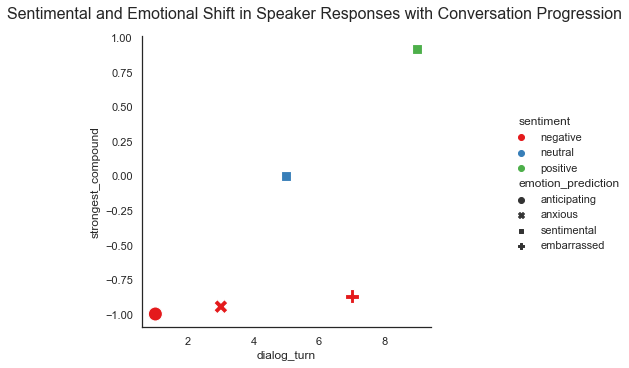

Number of turns:  10 , interleaved:  True , number of speaker tokens:  211 , speaker-listener turn diff:  None , threshold:  4 , ENGAGEMENT SCORE:  12.0 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.2 , sentiment change:  1.9 , grateful bonus:  1 , profanity penalty:  0 , sarcasm penalty:  0 , disagreement penalty:  0 , threshold:  2 , SATISFACTION SCORE:  4 , SATISFACTION :  highly satisfying
Classification summary:  highly engaging ,  highly satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,1,"I’m kinda worried about posting this here because I don’t know if it is correct or not but I’m stuck in a very bad anxiety hole atm, I posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry I don’t know how to do paragraphs) ok so recently every single day and night I’ve been having panic attacks over something that happened 2-3 years ago, when I was 13 I was on pornhub and came across Ben 10 hentai and being thirty I was very stupid a...",-0.9960,negative,anticipating,NaN,"[i’m kinda worried about posting this here because i don’t know if it is correct or not but i’m stuck in a very bad anxiety hole atm, i posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry i don’t know how to do paragraphs) ok so recently every single day and night i’ve been having panic attacks over something that happened 2-3 years ago, when i was 13 i was on pornhub and came across ben 10 hentai and being thirty i was very stupid ...",[-0.996],-0.9960
1,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,2,No it's not illegal and you won't get in trouble for it. Especially as pornhub is legal. There's weirder things on there like scooby doo or American dad sketches. We all get curious. There's nothing to worry about x,0.8477,positive,faithful,NaN,"[no it's not illegal and you won't get in trouble for it., especially as pornhub is legal., there's weirder things on there like scooby doo or american dad sketches., we all get curious., there's nothing to worry about x]","[0.4556, 0.128, 0.25, 0.3182, 0.3412]",0.4556
2,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,3,"Thank you so much, I’ve felt so bad for so long, I was at the point where I can’t handle it anymore, I know this whole thing sounds stupid but I have been having serious suicidal thoughts over it, after reading your comment I’m crying lol, I was so worried about posting this but I’m at the point where it was either a suicidal help line or this, I chose this because I wasn’t brave enough for the latter but seriously thank you I was so nervous, also please excuse my lack of ability to do parag...",-0.9430,negative,anxious,116.0,"[thank you so much, i’ve felt so bad for so long, i was at the point where i can’t handle it anymore, i know this whole thing sounds stupid but i have been having serious suicidal thoughts over it, after reading your comment i’m crying lol, i was so worried about posting this but i’m at the point where it was either a suicidal help line or this, i chose this because i wasn’t brave enough for the latter but seriously thank you i was so nervous, also please excuse my lack of ability to do para...",[-0.943],-0.9430
3,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,4,No problem. I was the same when I started exploring that side of the web. It's harmless x,0.5037,positive,sentimental,NaN,"[no problem., i was the same when i started exploring that side of the web., it's harmless x]","[0.3089, 0.0, 0.25]",0.3089
4,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,5,So do you really think I’ll be ok?,0.0000,neutral,sentimental,10.0,[so do you really think i’ll be ok?],[0.0],0.0000
5,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,6,Yeah for sure. Pornhub can't have anything illegal on there or they'll lose their licence,0.5753,positive,angry,NaN,"[yeah for sure., pornhub can't have anything illegal on there or they'll lose their licence]","[0.5423, 0.0577]",0.5423
6,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,7,"I was just really worried because i read that even hentai which is underage is illegal, 

In [126]:
test_examples(1732) 

### Highly engaging, highly satisfying (profanity & gratitude)

[[0.5574758]
 [0.5574758]
 [0.4291499]
 [0.5574758]]


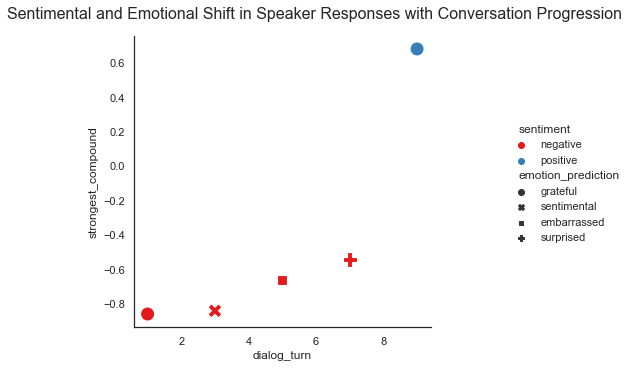

Number of turns:  10 , interleaved:  True , number of speaker tokens:  122 , speaker-listener turn diff:  None , threshold:  4 , ENGAGEMENT SCORE:  12.0 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.19 , sentiment change:  1.5 , grateful bonus:  1 , profanity penalty:  -1 , sarcasm penalty:  -1 , disagreement penalty:  0 , threshold:  2 , SATISFACTION SCORE:  2 , SATISFACTION :  highly satisfying
Classification summary:  highly engaging ,  highly satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,1,"A bit of background information. I smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder. I get really stressed out when I think about those episodes I had, and worry about death constantly. Recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year. I don’t know why, but that bothered me and put me in a really depressed moo...",-0.9820,negative,grateful,NaN,"[a bit of background information., i smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder., i get really stressed out when i think about those episodes i had, and worry about death constantly., recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year., i don’t know why, but that bothered me and put me in a really depressed m...","[0.0, -0.8581, -0.8588, 0.1027, -0.8334, 0.4404, -0.2023, -0.7003, -0.296, 0.0, 0.4019, -0.6003]",-0.8588
1,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,2,"Well, I'm going to take a stab at it and say that you have mixed feelings and anxiety because you've been raised to think of weed as a bad thing and it's been demonized. So there's already a stigma there for you when it comes to the drug. Then there's the other side of it, which is you tried it, you had a severe panic attack (which can happen depending on the type of weed. I've had one as well with some kinds, and not with others. And I've had depersonalization on weed too. Your frame of min...",-0.8813,negative,anxious,NaN,"[well, i'm going to take a stab at it and say that you have mixed feelings and anxiety because you've been raised to think of weed as a bad thing and it's been demonized., so there's already a stigma there for you when it comes to the drug., then there's the other side of it, which is you tried it, you had a severe panic attack (which can happen depending on the type of weed., i've had one as well with some kinds, and not with others., and i've had depersonalization on weed too., your frame ...","[-0.7845, 0.0, -0.8402, 0.2732, 0.0, 0.5106, -0.4679, 0.271, 0.0, -0.4019, 0.0, -0.5735, 0.0361, 0.5994, -0.6652, 0.0, -0.296, -0.296, 0.0, -0.296, 0.3089, 0.0, 0.0, -0.0516, -0.395, -0.5106, 0.2263, 0.0, -0.6956, 0.0, -0.5267, 0.0, 0.4019, 0.5106, 0.5023, 0.7755, 0.2675, 0.4019, 0.0]",-0.8402
2,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,3,"you hit the nail on the head with that egg analogy. except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts. i don’t know why.",-0.8402,negative,sentimental,41.0,"[you hit the nail on the head with that egg analogy., except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts., i don’t know why.]","[0.0, -0.8402, 0.0]",-0.8402
3,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,4,Awww. I’m sorry you feel that way. I’d look into why you’re having that reaction to it. 💗,0.6808,positive,sentimental,NaN,"[awww., i’m sorry you feel that way., i’d look into why you’re having that reaction to it., 💗]","[0.0, -0.0772, 0.0, 0.7096]",0.7096
4,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,5,i feel so alone in my life and it eats me up inside to hear that the one i love is having a normal reaction to it. i feel left out and angry at the same time and i just cut my wrists tonight to get my mind off of her. i’m a fucking wreck,-0.

In [127]:
test_examples(1003) 

### Highly engaging, less satisfying

[[0.5574758]
 [0.4291499]
 [0.4291499]]


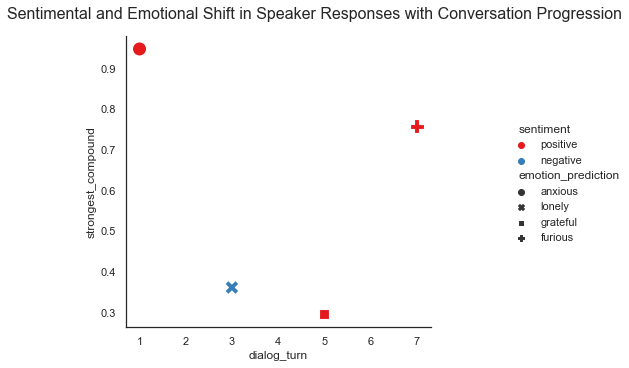

Number of turns:  8 , interleaved:  True , number of speaker tokens:  34 , speaker-listener turn diff:  None , threshold:  4 , ENGAGEMENT SCORE:  10.0 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.012 , sentiment change:  -0.19 , grateful bonus:  1 , profanity penalty:  0 , sarcasm penalty:  -1 , disagreement penalty:  0 , threshold:  2 , SATISFACTION SCORE:  1 , SATISFACTION :  less satisfying
Classification summary:  highly engaging ,  less satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,1,"Ok so I haven't been diagnosed with anything fwi. But it's gotten to the point where if I'm alone or not busy I get really depressed about random stuff, and I can't help it, I always put happy music on to try and help but it doesn't. I've had the most amazing weekend ever from Friday to Monday I was at a friend's house and ive never laughed so much in such a short amount of time in my life. But now (Tuesday) I just feel awful, empty, sad. And idk why. And I have this real problem where I g...",0.9023,positive,anxious,NaN,"[ok so i haven't been diagnosed with anything fwi., but it's gotten to the point where if i'm alone or not busy i get really depressed about random stuff, and i can't help it, i always put happy music on to try and help but it doesn't., i've had the most amazing weekend ever from friday to monday i was at a friend's house and ive never laughed so much in such a short amount of time in my life., but now (tuesday) i just feel awful, empty, sad., and idk why., and i have this real problem where...","[0.296, -0.1721, 0.3845, -0.8847, -0.1027, -0.7227, 0.8316, 0.0, 0.0, -0.4404, 0.1027, 0.9477]",0.9477
1,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,2,"Maybe your extroverted, and something else is making those feelings worse. It might just be that you really need to be around people. Don't worry, you're going to be okay. I'm really sorry, I really wish I could help more",0.6492,positive,guilty,NaN,"[maybe your extroverted, and something else is making those feelings worse., it might just be that you really need to be around people., don't worry, you're going to be okay., i'm really sorry, i really wish i could help more]","[-0.4767, 0.0, 0.5116, 0.6249]",0.6249
2,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,3,I'm not though. I like being inside the house. And there is something that makes everything worse but that's personal.,-0.3828,negative,lonely,22.0,"[i'm not though., i like being inside the house., and there is something that makes everything worse but that's personal.]","[0.0, 0.3612, -0.2617]",0.3612
3,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,4,"I'm really sorry. I'm not an expert, and I really wish I could help you. The most I can do is give you someone to talk to",0.6249,positive,sentimental,NaN,"[i'm really sorry., i'm not an expert, and i really wish i could help you., the most i can do is give you someone to talk to]","[-0.1513, 0.6901, 0.0]",0.6901
4,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,5,Does this sound like anything serious?,0.2960,positive,grateful,6.0,[does this sound like anything serious?],[0.296],0.2960
5,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,6,"From my very limited knowledge, it doesn't seem to be. It seems to be just something with your personality, not anything serious. But again, I'm not an expert. I'm sorry",-0.2348,negative,sentimental,NaN,"[from my very limited knowledge, it doesn't seem to be., it seems to be just something with your personality, not anything serious., but again, i'm not an expert., i'm sorry]","[-0.2944, 0.0572, 0.0, -0.0772]",-0.2944
6,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,7,"its okay, thanks for the help",0.7579,positive,furious,6.0,"[its okay, thanks for the help]",[0.7579],0.7579
7,854,MentalHealthSu

In [128]:
test_examples(854) 

### Less engaging, highly satisfying

[[0.4291499]]


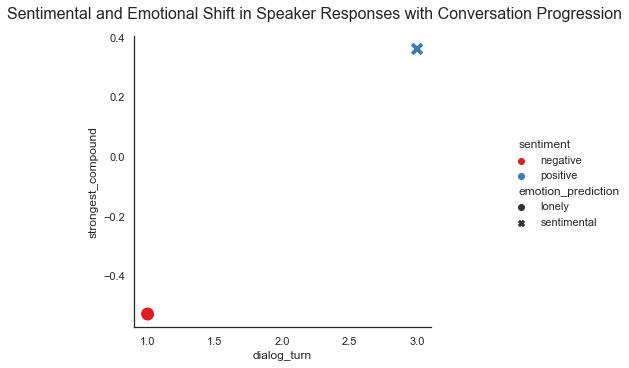

Number of turns:  3 , interleaved:  True , number of speaker tokens:  3 , speaker-listener turn diff:  1 , threshold:  4 , ENGAGEMENT SCORE:  3.2 , ENGAGEMENT:  less engaging
Sentiment slope:  0.5 , sentiment change:  0.89 , grateful bonus:  1 , profanity penalty:  0 , sarcasm penalty:  0 , disagreement penalty:  0 , threshold:  2 , SATISFACTION SCORE:  3 , SATISFACTION :  highly satisfying
Classification summary:  less engaging ,  highly satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,35,MentalHealthSupport,Losing hope,kelseybrynn,1,I'm not doing well today. I don't know how to contain or control my angst and abandonment issues.,-0.6386,negative,lonely,NaN,"[i'm not doing well today., i don't know how to contain or control my angst and abandonment issues.]","[-0.2057, -0.5267]",-0.5267
1,35,MentalHealthSupport,Losing hope,Leena52,2,"If it is interfering with your ability to work and function, then you may wish to seek out professional help. This sub is a good resource; however, you are worthy of more. If you can not get to a professional or find some one to interact with in person, you may need to spend some time focused on something that you enjoy, preferable outdoor time (sunlight is known to lift mood) or exercise (this is proven to help lift the mood by releasing the good brain chemicals). Staying focused on ones...",0.9837,positive,anticipating,NaN,"[if it is interfering with your ability to work and function, then you may wish to seek out professional help., this sub is a good resource; however, you are worthy of more., if you can not get to a professional or find some one to interact with in person, you may need to spend some time focused on something that you enjoy, preferable outdoor time (sunlight is known to lift mood) or exercise (this is proven to help lift the mood by releasing the good brain chemicals)., staying focused on one...","[0.7717, 0.7003, 0.886, -0.128, 0.4404, 0.7096]",0.8860
2,35,MentalHealthSupport,Losing hope,kelseybrynn,3,Thank you...,0.3612,positive,sentimental,3.0,[thank you...],[0.3612],0.3612


In [129]:
test_examples(35) 

[[0.779613]]


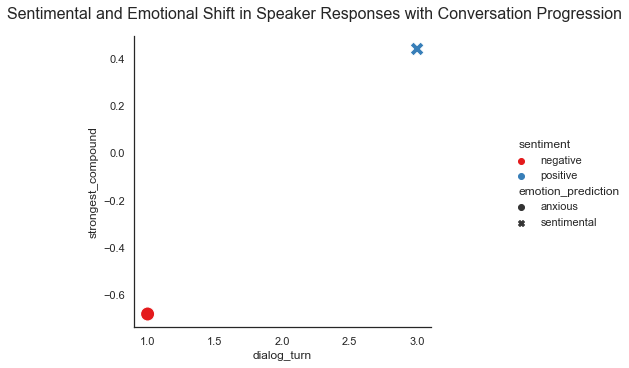

Number of turns:  3 , interleaved:  True , number of speaker tokens:  43 , speaker-listener turn diff:  1 , threshold:  4 , ENGAGEMENT SCORE:  4.5 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.63 , sentiment change:  1.1 , grateful bonus:  1 , profanity penalty:  0 , sarcasm penalty:  -1 , disagreement penalty:  -1 , threshold:  2 , SATISFACTION SCORE:  1 , SATISFACTION :  less satisfying
Classification summary:  highly engaging ,  less satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,1,"How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, "" we pay for that, dont we?"" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.",-0.8225,negative,anxious,NaN,"[how they knew ill never know..., but someone told them that shouldnt have..., here goes..., i was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things., ., and the cashier says, "" we pay for that, dont we?"", in relation to my purchase., how in the hell did a cashier know i was on disability?, giving me a reason, without an identifiable motive is a good way to get yourself hurt., keep it up.]","[-0.4215, 0.0, 0.0, 0.0531, 0.0, -0.1027, 0.0, -0.6808, 0.2263, 0.0]",-0.6808
1,24,MentalHealthSupport,Threatened by a stranger about mental disability.,shatterSquish,2,"That doesn't sound at all like they knew you were on disability. I think you're jumping to conclusions here. For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.",0.3400,positive,anxious,NaN,"[that doesn't sound at all like they knew you were on disability., i think you're jumping to conclusions here., for example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.]","[0.3612, 0.0, -0.0258]",0.3612
2,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,3,"Hey squish. Thanks for not just telling me it was ""all in my head."" A. I wasnt shoplifting. And B. The phrase ""We pay for that, dont we?"" is not a normal phrase. Appreciate your input, but i disagree.",0.4404,positive,sentimental,43.0,"[hey squish., thanks for not just telling me it was ""all in my head."", a. i wasnt shoplifting., and b., the phrase ""we pay for that, dont we?"", is not a normal phrase., appreciate your input, but i disagree.]","[0.0, 0.4404, 0.0, 0.0, -0.1027, 0.0, -0.3716]",0.4404


In [130]:
test_examples(24)